<img src="FIGURES/GIGGLES_FALL_2017.001.jpeg" />

<img src="FIGURES/GIGGLES_FALL_2017.002.jpeg" />

<img src="FIGURES/GIGGLES_FALL_2017.011.jpeg" />

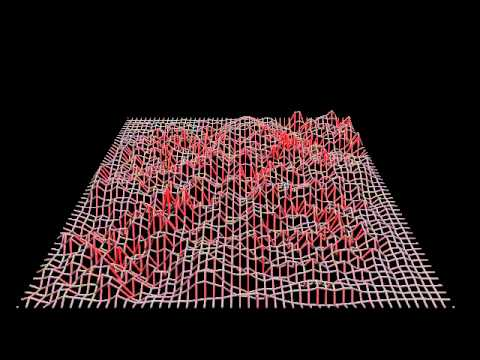

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('4rYOF14Km9s')

---
# Ambient Noise Cross-Correlation 
- We want to find the Green's function $G_{AB}$, or impulse response, between seismometers $A$ and $B$.  

- The cross-correlation $C_{AB}$ of a completely random wave-field $F(t)$ converges to the complete Green’s function $G_{AB}(t)$ of the medium.

$$ \large \lim_{t\to\infty} \frac{\partial}{\partial t}C_{AB}(t) \approx F(t) * [G_{AB}(t) - G_{BA}(-t)] $$

where the cross-correlation $C_{AB}$ is defined

$$ \large C_{AB}(\tau )\ =\int _{-\infty }^{\infty }A^{*}(t)\ B(t+\tau )\, dt$$

In the frequency domain, this simplifies to 

$$  \large \mathcal{C}_{AB}(\omega) = A(\omega)^* \cdot B(\omega)$$

- This means all we only need to cross-correlate data at two stations to recover the Green's function between them. 

---
# (Hydro)Seismology Data Processing 

In [2]:
# python modules 
import sys
import os 
import glob 
import datetime 

# array, numerical and plotting modules 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import pandas as pd 
import mpld3

# seismology module
import obspy 

---
## Load Raw Data using Obspy

In [3]:
# load raw data using Obspy
RIO = "/Users/thclements/Desktop/GIGGLES_DATA/RIO"
RIO_mseed = os.path.join(RIO,"*.mseed")
RUS = "/Users/thclements/Desktop/GIGGLES_DATA/RUS"
RUS_mseed = os.path.join(RUS,"*.mseed")

st1 = obspy.read(RIO_mseed)
st2 = obspy.read(RUS_mseed)
print(st1)
print(st1[0].stats)

1 Trace(s) in Stream:
CI.RIO..BHZ | 2016-01-01T00:00:00.019500Z - 2016-01-02T00:00:38.044500Z | 40.0 Hz, 3457522 samples
         network: CI
         station: RIO
        location: 
         channel: BHZ
       starttime: 2016-01-01T00:00:00.019500Z
         endtime: 2016-01-02T00:00:38.044500Z
   sampling_rate: 40.0
           delta: 0.025
            npts: 3457522
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'record_length': 4096, 'byteorder': '>', 'dataquality': 'D', 'encoding': 'STEIM1', 'filesize': 7503872, 'number_of_records': 1832})


---
## Plot Waveforms 

/Users/thclements/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


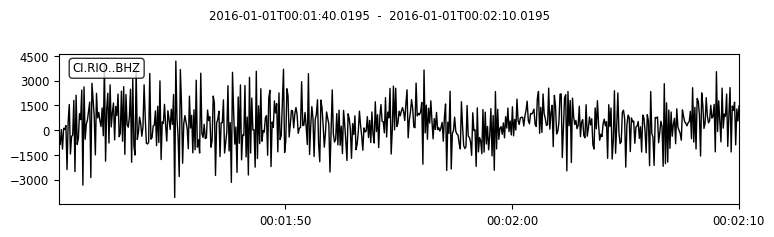

/Users/thclements/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


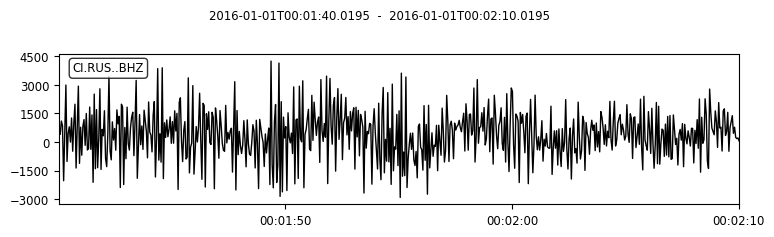

In [4]:
# plot waveforms 
tr1 = st1[0].interpolate(20.)
tr2 = st2[0].interpolate(20.)
t1,t2 = tr1.stats.starttime,tr1.stats.endtime
t3,t4 = tr2.stats.starttime,tr2.stats.endtime
t1,t2 = np.max([t1,t3]),np.min([t2,t4])
tr1,tr2 = tr1.slice(t1,t2),tr2.slice(t1,t2)
tr1.plot(starttime=t1+100,endtime = t1 + 130)
tr2.plot(starttime=t1+100,endtime = t1 + 130)

---
## Plot Spectrogram 

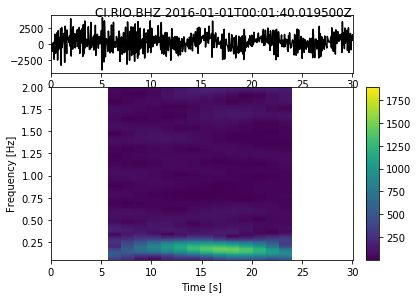

In [5]:
sys.path.append('/Users/thclements/odyssey')
from tools import spect
spect(tr1.copy().slice(t1+100,t1+130),fmin = 0.05,fmax=2.)

---
## Preprocessing 
- Before we can cross-correlate, we need to clean up our data:
        - Remove the mean of each waveform (demean)
        - Remove any linear trends in the waveform (detrend)
        - Taper the waveform to zero at either end 
        - Bandpass filter the waveform to remove low and high frequency components 

/Users/thclements/pyasdf/pyasdf/asdf_data_set.py:51: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  closure_warn(self, *args, **kwargs)
/Users/thclements/pyasdf/pyasdf/asdf_data_set.py:51: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  closure_warn(self, *args, **kwargs)


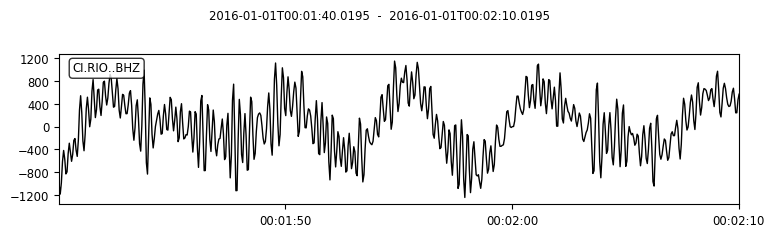

/Users/thclements/pyasdf/pyasdf/asdf_data_set.py:51: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  closure_warn(self, *args, **kwargs)


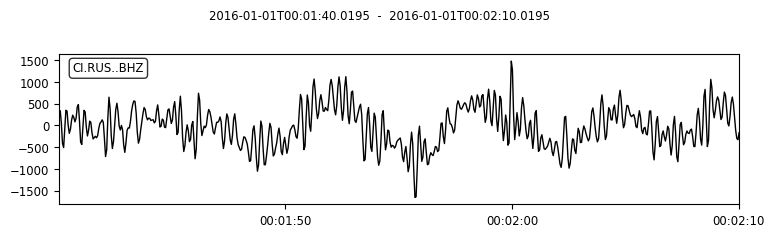

In [6]:
from obspy.signal.filter import bandpass
def clean_up(data,sampling_rate,freqmin,freqmax):
    if data.ndim == 2:
        axis = 1
    else:
        axis = 0
    data = scipy.signal.detrend(data,axis=axis,type='constant')
    data = scipy.signal.detrend(data,axis=axis,type='linear')
    percent = sampling_rate * 20 / data.shape[axis]
    taper = scipy.signal.tukey(data.shape[axis],percent)
    data *= taper
    data = bandpass(data,freqmin,freqmax,sampling_rate,zerophase=True)
    return data

freqmin,freqmax = 0.005,4.0
tr1.data = clean_up(tr1.data,tr1.stats.sampling_rate,freqmin,freqmax)
tr2.data = clean_up(tr2.data,tr2.stats.sampling_rate,freqmin,freqmax)
tr1.plot(starttime=t1+100,endtime = t1 + 130)
tr2.plot(starttime=t1+100,endtime = t1 + 130)

---
### Transform to Frequency Domain 

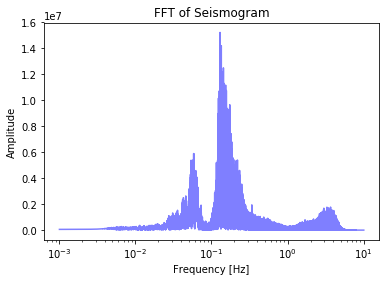

In [7]:
from scipy.fftpack.helper import next_fast_len
Nfft = next_fast_len(int(tr1.data.shape[0]))
fft1 = scipy.fftpack.fft(tr1.data,Nfft)
freqs = scipy.fftpack.fftfreq(Nfft, d=tr1.stats.delta)[:Nfft // 2]
ind = np.where(freqs > 0.001)[0]

# plot frequency data 
plt.semilogx(freqs[ind],np.abs(fft1[:Nfft//2][ind]),'b-',alpha =0.5)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('FFT of Seismogram')
plt.show()

---
## Frequency Domain Whitening 
- The theory above applies for a single frequency $\omega$ and assumes that all frequencies have equal power.
- The noise spectrum in the Earth is not white (Shearer, 2009). 
<img src="FIGURES/Shearer_2009.jpg">
----

### Seasonal Change in Ambient Noise

- We also have to worry about seasonality in the ambient noise (Zhan et al., 2013). 

<img src="FIGURES/seasonal.png" width="400">

---
### Complex Number Aside 
The outputs of an $\texttt{fft}$ are complex. Recall that a complex number $z$ can be expressed as

$$ \large z = r(\cos \phi + i \sin \phi) = r e^{i \phi}$$

<img src="FIGURES/complex.png" >

---
### Whitening 

So to "whiten" the frequency spectrum, we can just set $r = 1$ in a certain frequency band of our $\texttt{fft}$.

``` python 
whitened = np.exp(1j * np.angle(fft1))

```

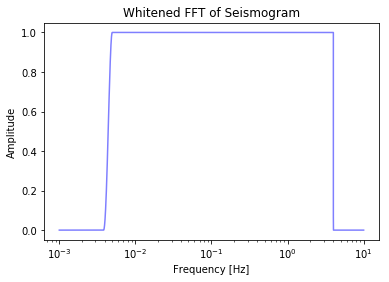

In [8]:
from compute_cc import whiten 
white1 = whiten(tr1.copy().data,tr1.stats.delta,freqmin,freqmax,Nfft)
white2 = whiten(tr2.copy().data,tr1.stats.delta,freqmin,freqmax,Nfft)
plt.semilogx(freqs[ind],np.abs(white1[:Nfft//2][ind]),'b-',alpha =0.5)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('Whitened FFT of Seismogram')
plt.show()

---
### Transform Whitened Spectrum to Time Domain 

/Users/thclements/pyasdf/pyasdf/asdf_data_set.py:51: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  closure_warn(self, *args, **kwargs)


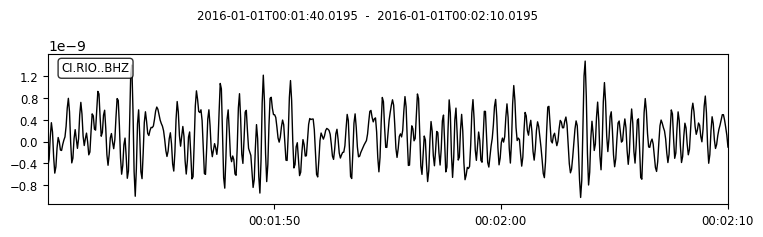

/Users/thclements/pyasdf/pyasdf/asdf_data_set.py:51: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  closure_warn(self, *args, **kwargs)


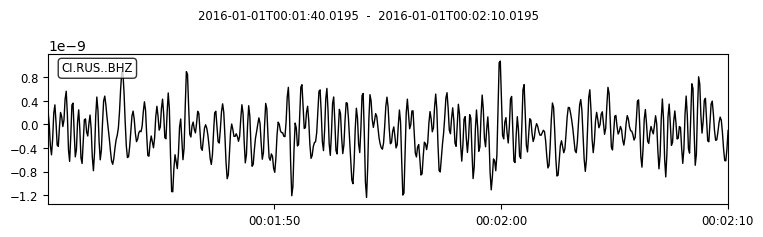

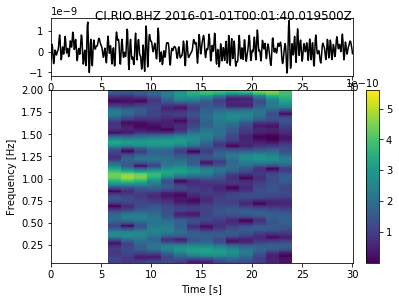

In [9]:
# take inverse fft 
twhite1 = np.real(scipy.fftpack.ifft(white1, Nfft)) / Nfft
twhite2 = np.real(scipy.fftpack.ifft(white2, Nfft)) / Nfft
twhite1 = np.concatenate((twhite1[-Nfft + 1:], twhite1[:Nfft + 1]))
twhite2 = np.concatenate((twhite2[-Nfft + 1:], twhite2[:Nfft + 1]))

# update data and plot
tr1.data,tr2.data = twhite1,twhite2
tr1.plot(starttime=t1+100,endtime = t1 + 130)
tr2.plot(starttime=t1+100,endtime = t1 + 130)
print("\n\n\n\n")
spect(tr1.copy().slice(t1+100,t1+130),fmin = 0.05,fmax=2.)

----
## One-bit Normalization 
- It has been shown that cross-correlating the sign (+1/-1) of a waveform increases SNR. 
- This give more importance to the longest scattering paths. 
- This essentially makes the signal phase - only 
``` python 
onebit = np.sign(data)
```

/Users/thclements/pyasdf/pyasdf/asdf_data_set.py:51: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  closure_warn(self, *args, **kwargs)


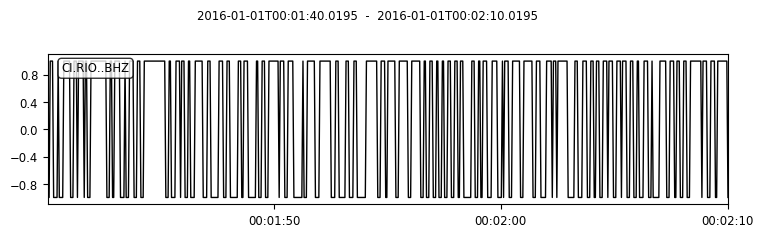

/Users/thclements/pyasdf/pyasdf/asdf_data_set.py:51: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  closure_warn(self, *args, **kwargs)


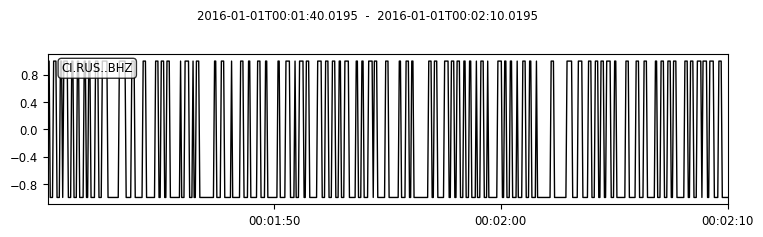

In [10]:
# apply one bit 
tr1.data = np.sign(tr1.data)
tr2.data = np.sign(tr2.data)
tr1.plot(starttime=t1+100,endtime = t1 + 130)
tr2.plot(starttime=t1+100,endtime = t1 + 130)

---
## Cross-correlation

- The last thing we need to do is cross-correlate the whitened and one-bit normalized signals

$$  \large \mathcal{C}_{AB}(\omega) = A(\omega)^* \cdot B(\omega)$$

where we have $ A(\omega) =  \texttt{fft}(A) $ and $ B(\omega) =  \texttt{fft}(B) $

- Once we have $\texttt{fft}(A)$ and $\texttt{fft}(B)$, the cross-correlation is just 

``` python 
corr = np.conj(fftA) * fftB
```


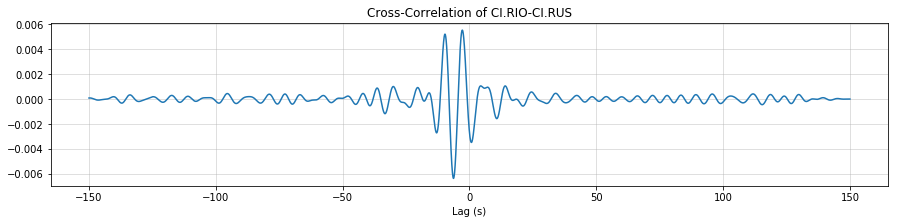

In [11]:
# take fft
fft1 = scipy.fftpack.fft(tr1.data, Nfft)
fft1[-(Nfft // 2) + 1:] = fft1[1:(Nfft // 2)].conjugate()[::-1]

fft2 = scipy.fftpack.fft(tr2.data, Nfft)
fft2[-(Nfft // 2) + 1:] = fft2[1:(Nfft // 2)].conjugate()[::-1]

# cross-correlate
maxlag = 150
Nt = fft1.shape[0]
corr = np.conj(fft1) * fft2
corr = np.real(scipy.fftpack.ifft(corr, Nfft)) / Nt
corr = np.concatenate((corr[-Nt + 1:], corr[:Nt + 1]))
tcorr = np.arange(-Nt + 1, Nt)
dN = np.where(np.abs(tcorr)/ tr1.stats.sampling_rate <= maxlag)[0]
corr = corr[dN]

corr = clean_up(corr,tr1.stats.sampling_rate,0.1,0.2)
fig = plt.figure(figsize = (15,3))
plt.plot(tcorr[dN]/tr1.stats.sampling_rate,corr)
plt.xlabel('Lag (s)')
plt.title('Cross-Correlation of {}.{}-{}.{}'.format(tr1.stats.network,tr1.stats.station,tr2.stats.network,tr2.stats.station))
plt.grid('on',alpha = 0.5)
plt.show()

---
## 15 years of Cross-Correlations!
...interlude for Odyssey to do some magic

<img src="FIGURES/MWC_RIO_0.5_2.0.png" >

- Note how specific arrivals in the coda change through time 

    - Seasonality? 
    
    - Or groundwater??

--- 

# Variations in seismic velocity (dv/v)

- We want track how seismic velocity changes on a daily basis 

- The classic way to do this is to compare the daily cross-correlation to the stack of all cross-correlations 

- We call the stack of all cross-correlations the reference cross-correlation

### Reference Cross-Correlation  


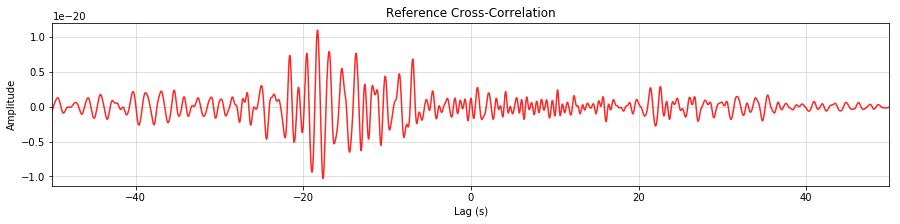

In [12]:
import pyasdf 
ref_ds = pyasdf.ASDFDataSet('/Users/thclements/Desktop/GIGGLES_DATA/REF_CORR/CI_RIO_CI_RUS.h5')
ref = np.array(ref_ds.auxiliary_data.Reference.CI_RIO_CI_RUS.ZZ.ref_CI_RIO_CI_RUS_ALL.data)
ref_param = ref_ds.auxiliary_data.Reference.CI_RIO_CI_RUS.ZZ.ref_CI_RIO_CI_RUS_ALL.parameters
lag = ref_param['lag']
t = np.linspace(-lag,lag,ref.shape[0])
ind = np.where(np.abs(t) < 50)[0]
t50, ref50 = t[ind],ref[ind]

# plot 
fig,ax = plt.subplots(figsize = (15,3))
plt.plot(t50,ref50,'r',alpha = 0.85)
plt.xlabel('Lag (s)')
plt.ylabel('Amplitude')
plt.title('Reference Cross-Correlation')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid('on',alpha = 0.5)
plt.show()

--- 
## Cross-Correlation time shifts 
- Let's simulate a change in velocity with respect to the reference cross-correlation 

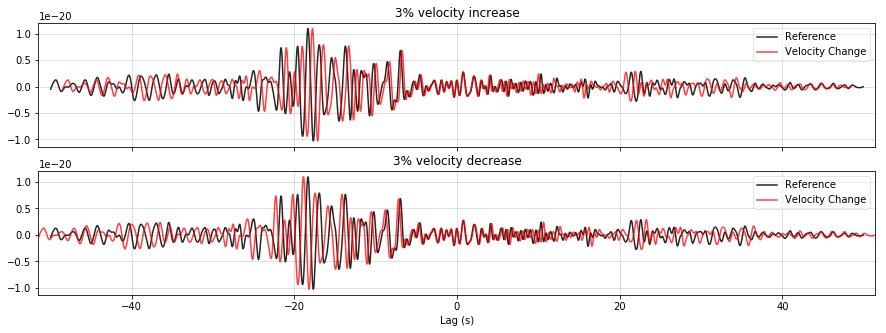

In [13]:
fig,ax = plt.subplots(2,1,sharex=True,figsize = (15,5))

ax[0].plot(t50,ref50,'k',alpha = 0.85,label = 'Reference')
ax[0].plot(t50*.97,ref50,'r',alpha = 0.75,label='Velocity Change')
ax[0].set_title('3% velocity increase')
ax[0].grid('on',alpha = 0.5)
ax[0].legend(loc='best',fancybox=True,framealpha = 0.5,fontsize = 10)

ax[1].plot(t50,ref50,'k',alpha = 0.85,label = 'Reference')
ax[1].plot(t50*1.03,ref50,'r',alpha = 0.75,label='Velocity Change')
ax[1].set_title('3% velocity decrease')
ax[1].set_xlabel('Lag (s)')
ax[1].legend(loc='best',fancybox=True,framealpha = 0.5,fontsize = 10)
plt.autoscale(enable=True, axis='x', tight=True)
ax[1].grid('on',alpha = 0.5)
plt.show()


## dt/t from Moving Window Cross-Spectrum 
- We want to find the global velocity change $dv/v$ for each day 
- Recovering the absolute velocity $v$ between two seismometers is easy from the distance formula 

$$ x = v  t $$

where $x$ is the distance between the seismometers and $t$ is the arrival of phase in the cross-corrrelation

- If we introduce a perturbation to the velocity $dv$ and time arrival $dt$, we have 

$$ x = (v + dv) ( t + dt) = vt + v dt + dvt + dv dt $$

- Canceling $x = vt$ and ignoring $dv dt$ gives 

$$ dt/t = - dv/v $$

- To measure $dt/t$:
    - Divide each cross-correlation function into $N$ windows 
    - Measure $dt$ in that window 
    - Fit a slope to all $dt$ measurements
    
### MWCS

Computing MWCS CI_RIO_CI_RUS-ALL 2006-08-01 00:00:00


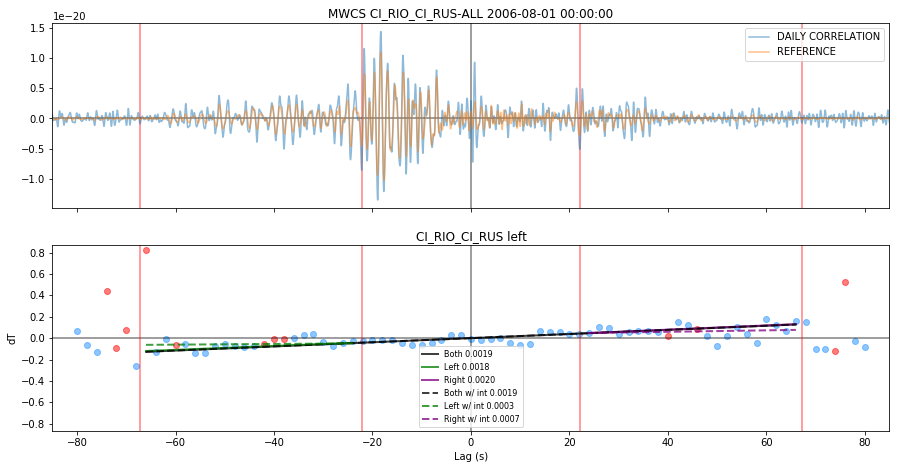

In [15]:
import plot_dtt 
corr_h5 = '/Users/thclements/Desktop/GIGGLES_DATA/CORR_ALL/CI_RIO_CI_RUS.h5'
date = datetime.datetime(2006,8,1)
num_stack = 30
freqmin,freqmax = 0.5,2.0
tmin, windL = -lag,10
step = 0.2 * windL
smoothing_half_win = 3
dtt_v = 2.
dtt_width = 45
minCoh,maxErr,maxDt = 0.5,0.1,0.5
plot_dtt.main(corr_h5,'ZZ',date,num_stack,freqmin,freqmax,
     tmin,windL,step,smoothing_half_win,dtt_v,
     dtt_width,minCoh,maxErr,maxDt,maxT = 85)

<img src="FIGURES/GIGGLES_FALL_2017.013.jpeg" />

<img src="FIGURES/GIGGLES_FALL_2017.014.jpeg" />

<img src="FIGURES/GIGGLES_FALL_2017.012.jpeg" />